In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools
from scipy.stats import randint

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.36223,65617.54375,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.38615,60379.32748,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.77382,50850.15596,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.92753,45374.51090,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.32914,54461.24651,84.167414,1.881007,4.476298,1.874052


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)

X_train_fso_rf1,X_train_fso_rf2,y_FSO_train_rf1,y_FSO_train_rf2=train_test_split(
    X_train,y_FSO_train,train_size=0.5,test_size=0.5,random_state=1874845,stratify=X_train['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train_rfl_rf1,X_train_rfl_rf2,y_RFL_train_rf1,y_RFL_train_rf2=train_test_split(
    X_train,y_RFL_train,train_size=0.5,test_size=0.5,random_state=1874845,stratify=X_train['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#define function to create interaction
def create_interaction_terms(df, interaction_vars):
    df_interactions=pd.DataFrame()
    for var in interaction_vars:
        if '*' in var:
            var1, var2 = var.split('*')
            df_interactions[var] = df[var1] * df[var2]
        else:
            df_interactions[var] = df[var]
    return df_interactions
def Generate_interaction_terms(df, features):
    interaction_data = df.copy()
    for feat1, feat2 in itertools.combinations(features, 2):
        interaction_name = f"{feat1} * {feat2}"
        interaction_data[interaction_name] = df[feat1] * df[feat2]
    return interaction_data
variables = {
    'Overall_FSO_Att': ['Time','TemperatureMin','Particulate','AbsoluteHumidity','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['Visibility','RainIntensityMin','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity']
}

In [5]:
#Prepare RFL trainset for FSO-RFL hybrid model
X_train_fso=create_interaction_terms(X_train_rfl_rf2,variables['Overall_FSO_Att'])
X_train_FSO_rf1=create_interaction_terms(X_train_fso_rf1,variables['Overall_FSO_Att'])
X_test_fso=create_interaction_terms(X_test,variables['Overall_FSO_Att'])
overall_fso=RandomForestRegressor(max_depth=31,max_features='sqrt',min_samples_leaf=1, min_samples_split=3, n_estimators=161,n_jobs=-1)
#Fitting FSO model
overall_fso.fit(X_train_FSO_rf1,y_FSO_train_rf1)
FSO_pred=overall_fso.predict(X_train_fso)
FSO_test_pred=overall_fso.predict(X_test_fso)
print(FSO_pred.shape)
#add FSO_pred into RFL trainset
X_train_RFL=X_train_rfl_rf2.copy()
X_train_RFL['FSO_pred']=FSO_pred
print(X_train_RFL)


(36552,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
86921         18.628752            19.686233            17.639949   
55115          5.238019             5.650268             5.042022   
9441          16.190707            17.342568            14.761206   
65802          3.748091             3.897732             3.412643   
4412          19.103606            19.548981            17.535329   
...                 ...                  ...                  ...   
10848         15.313473            15.695952            14.181266   
29521          7.755772             8.108541             7.505703   
70125          6.742123             7.148423             6.294876   
87495         15.641325            16.713834            14.331695   
78167          4.642564             4.804410             4.229455   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
86921  3967.411950  73500000000     0.000000        0.000000        0.000000   
55

In [6]:
#Prepare FSO trainset for RFL-FSO hybrid model
X_train_rfl=create_interaction_terms(X_train_fso_rf2,variables['Overall_RFL_Att'])
X_train_RFL_rf1=create_interaction_terms(X_train_rfl_rf1,variables['Overall_RFL_Att'])
X_test_rfl=create_interaction_terms(X_test,variables['Overall_RFL_Att'])
overall_rfl=RandomForestRegressor(max_depth=39,max_features='sqrt',min_samples_leaf=1, min_samples_split=2, n_estimators=110,n_jobs=-1)
#Fitting RFL model   
overall_rfl.fit(X_train_RFL_rf1,y_RFL_train_rf1)
RFL_pred=overall_rfl.predict(X_train_rfl)
RFL_test_pred=overall_rfl.predict(X_test_rfl)
print(RFL_pred.shape)
#add RFL_pred into FSO trainset
X_train_FSO=X_train_fso_rf2.copy()
X_train_FSO['RFL_pred']=RFL_pred
print(X_train_FSO)

(36552,)
       AbsoluteHumidity  AbsoluteHumidityMax  AbsoluteHumidityMin  \
86921         18.628752            19.686233            17.639949   
55115          5.238019             5.650268             5.042022   
9441          16.190707            17.342568            14.761206   
65802          3.748091             3.897732             3.412643   
4412          19.103606            19.548981            17.535329   
...                 ...                  ...                  ...   
10848         15.313473            15.695952            14.181266   
29521          7.755772             8.108541             7.505703   
70125          6.742123             7.148423             6.294876   
87495         15.641325            16.713834            14.331695   
78167          4.642564             4.804410             4.229455   

          Distance    Frequency  Particulate  ParticulateMax  ParticulateMin  \
86921  3967.411950  73500000000     0.000000        0.000000        0.000000   
55

In [7]:
#Variables
variables_rf_2={
    'RFL_Att_rf_2':['FSO_pred','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity'],
    'FSO_Att_rf_2':['Time','TemperatureMin','AbsoluteHumidity','Particulate','RFL_pred','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance']
}

In [8]:
# fit model
def fs(trainX, trainy, testX,testy,Model):
    model=Model
    model.n_jobs=-1
    model.fit(trainX,trainy)
    y_pred=model.predict(testX)
    return y_pred,model

In [9]:
#define plot function
def plot_results(results,Type):
    # Extract data from result_RFL
    features = results['feature']
    rmse_values = results['RMSE']
    r2_values = results['R2_score']

    # Create the figure and subplots
    fig,ax1 = plt.subplots( figsize=(10, 6), sharex=False)

    # Plotting result
    ax1.plot(features, rmse_values, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features',fontsize=14)
    ax1.set_ylabel('RMSE', color='blue',fontsize=14)
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features, r2_values, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red',fontsize=14)
    ax1_twin.tick_params(axis='y', colors='red')
    if Type=='RFL':
        ax1.set_title('RFL model Feature Importance Analysis',fontsize=14)
    else:
        ax1.set_title('FSO model Feature Importance Analysis',fontsize=14)
    plt.tight_layout()

    # Show the combined plot
    plt.show()

In [10]:
# Function to perform hyperparameter tuning
def hyperparameter_tuning(X_train, y_train):
    # Define the parameter grid
    param_dist = {
        'n_estimators': randint(50,300), 
        'max_depth': randint(10,50),   
        'min_samples_split': randint(2,10),
        'min_samples_leaf': randint(1, 4),   
        'max_features': ['log2','sqrt'],
    }

    # Initialize the RandomForest model
    rf = RandomForestRegressor(random_state=1874845)

    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_dist, 
        n_iter=50, 
        cv=3,  
        scoring='neg_mean_squared_error',
        verbose=2,  
        random_state=42, 
        n_jobs=-1  
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_rf = random_search.best_estimator_

    print(f"Best Parameters: {random_search.best_params_}")

    return best_rf, random_search.cv_results_

In [11]:
def process(Type):
    if Type=='RFL':
        fso_test_pred=overall_fso.predict(create_interaction_terms(X_test,variables['Overall_FSO_Att']))
        X_RFL_test=X_test.copy()   
        X_RFL_test['FSO_pred']=fso_test_pred
        X_train_rfl=create_interaction_terms(X_train_RFL,variables_rf_2['RFL_Att_rf_2'])
        X_rfl_test=create_interaction_terms(X_RFL_test,variables_rf_2['RFL_Att_rf_2'])
        best_model_RFL, cv_results_RFL = hyperparameter_tuning(X_train_rfl, y_RFL_train_rf2)
        y_pred,model = fs(X_train_rfl, y_RFL_train_rf2, X_rfl_test, y_RFL_test,best_model_RFL)
        return y_pred,model
    else:
        rfl_test_pred=overall_rfl.predict(create_interaction_terms(X_test,variables['Overall_RFL_Att']))
        X_FSO_test=X_test.copy()   
        X_FSO_test['RFL_pred']=rfl_test_pred
        X_train_fso=create_interaction_terms(X_train_FSO,variables_rf_2['FSO_Att_rf_2'])
        X_fso_test=create_interaction_terms(X_FSO_test,variables_rf_2['FSO_Att_rf_2'])
        best_model_FSO, cv_results_FSO = hyperparameter_tuning(X_train_fso, y_FSO_train_rf2)
        y_pred,model = fs(X_train_fso, y_FSO_train_rf2, X_fso_test, y_FSO_test,best_model_FSO)
        return y_pred,model

In [12]:
y_pred_RFL,rf_2_RFL=process('RFL')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'max_depth': 49, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 160}


In [13]:
y_pred_FSO,rf_2_FSO=process('FSO')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'max_depth': 38, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 138}


In [14]:

y_pred_RFL_df = pd.DataFrame(y_pred_RFL, columns=['y_pred_RFL'])
y_pred_FSO_df = pd.DataFrame(y_pred_FSO, columns=['y_pred_FSO'])
FSO_pred_df = pd.DataFrame(FSO_pred, columns=['FSO_pred'])
RFL_pred_df = pd.DataFrame(RFL_pred, columns=['RFL_pred'])

In [15]:
results = pd.DataFrame({
    'SYNOPCode': X_test['SYNOPCode'],
    'y_pred_FSO_2': y_pred_FSO,
    'y_pred_RFL_2': y_pred_RFL,
    'FSO_pred_1': FSO_test_pred,
    'RFL_pred_1': RFL_test_pred,
    'y_FSO_test': y_FSO_test,
    'y_RFL_test': y_RFL_test
})
print(results)

       SYNOPCode  y_pred_FSO_2  y_pred_RFL_2  FSO_pred_1  RFL_pred_1  \
68601          6     13.944301     22.064467   14.150693   22.082634   
68115          0      4.750444     12.036986    4.572158   12.015208   
28357          0      2.969241     11.086849    2.995905   11.184096   
17893          0      6.364846      6.942091    6.829858    6.881156   
60284          5     10.213862     13.158907   10.522850   12.882341   
...          ...           ...           ...         ...         ...   
66872          0      6.509195     11.940558    6.701314   11.981993   
88377          0      9.827965     10.907252    9.120513   10.971968   
42756          0      2.637961     11.323496    2.684996   11.162264   
7730           5      9.603609      9.652505   10.405751    9.703708   
41634          0      3.000933     11.625773    3.323552   11.466527   

       y_FSO_test  y_RFL_test  
68601   13.077835   22.047411  
68115    4.450609   12.125053  
28357    2.890493   10.979996  
17893  

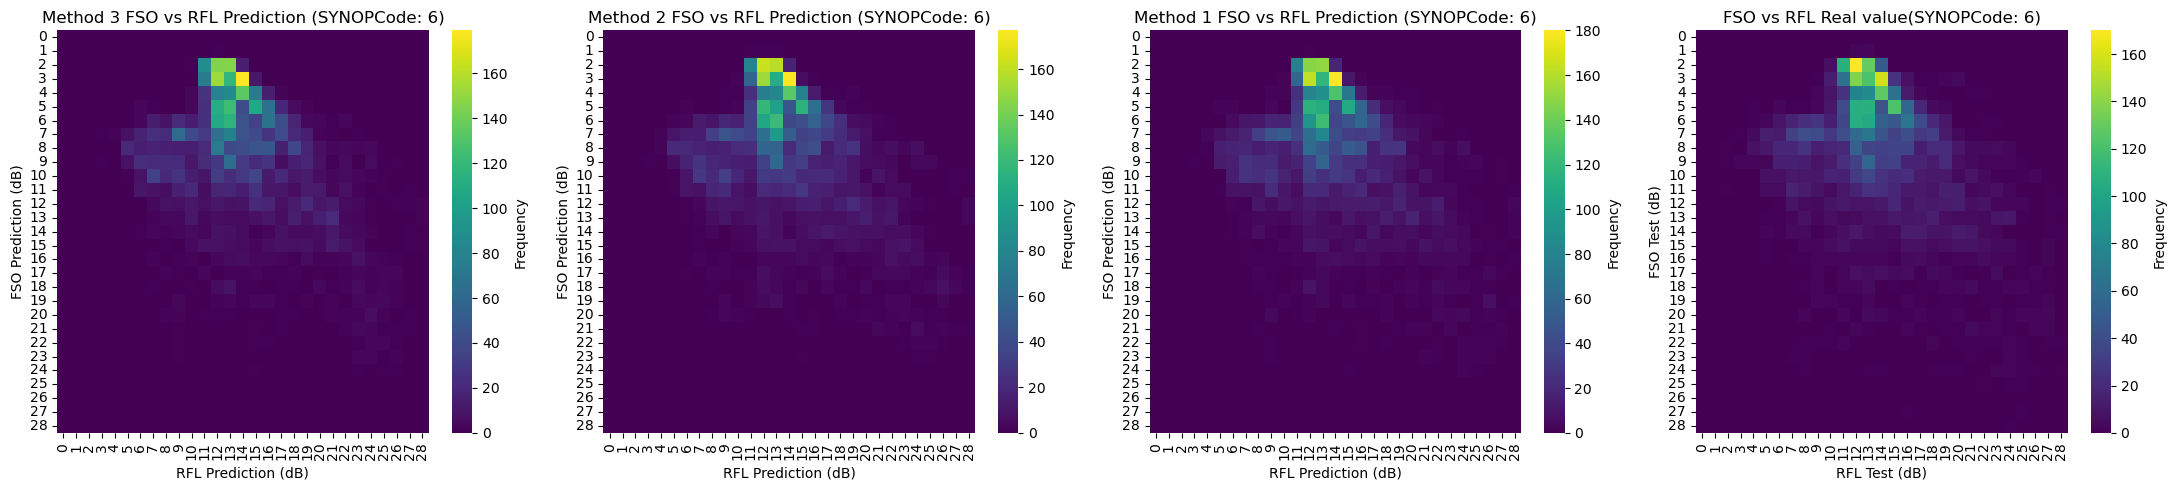

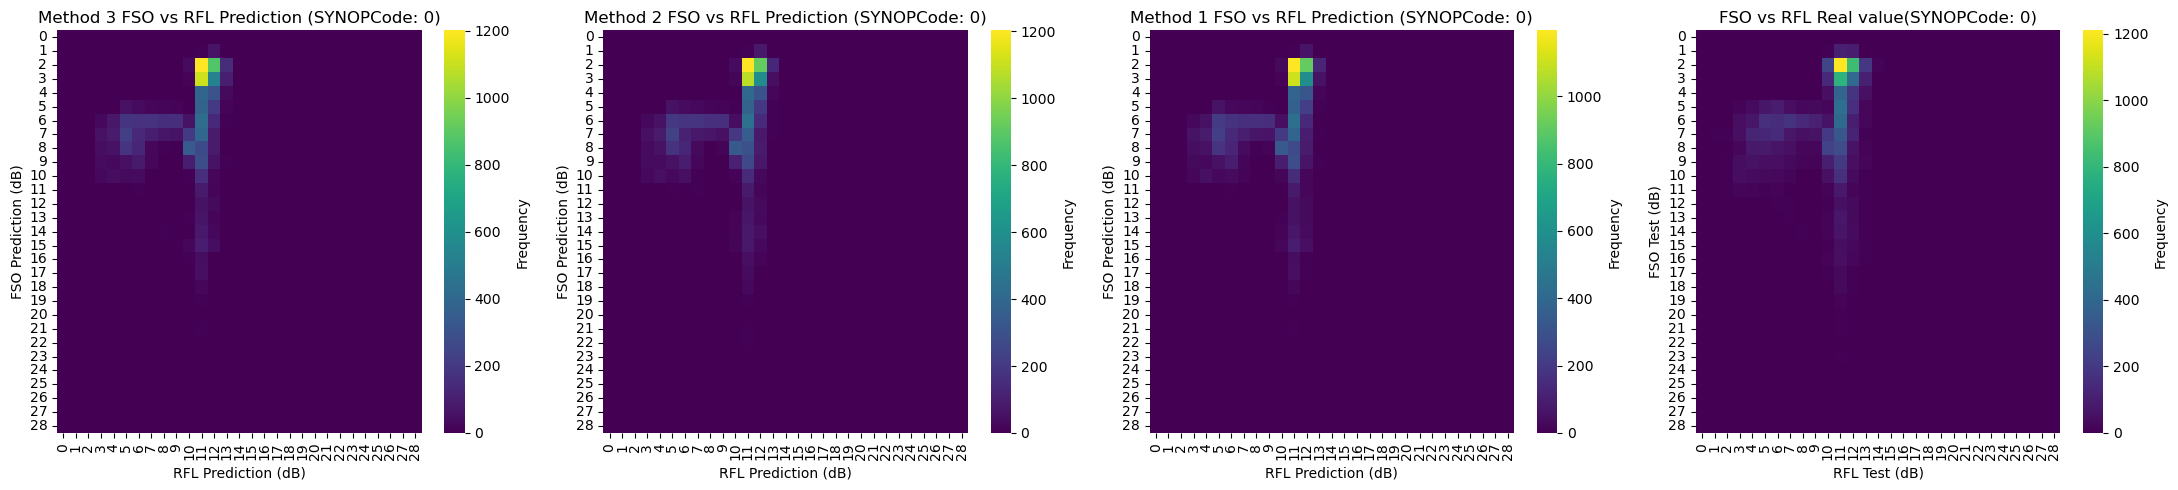

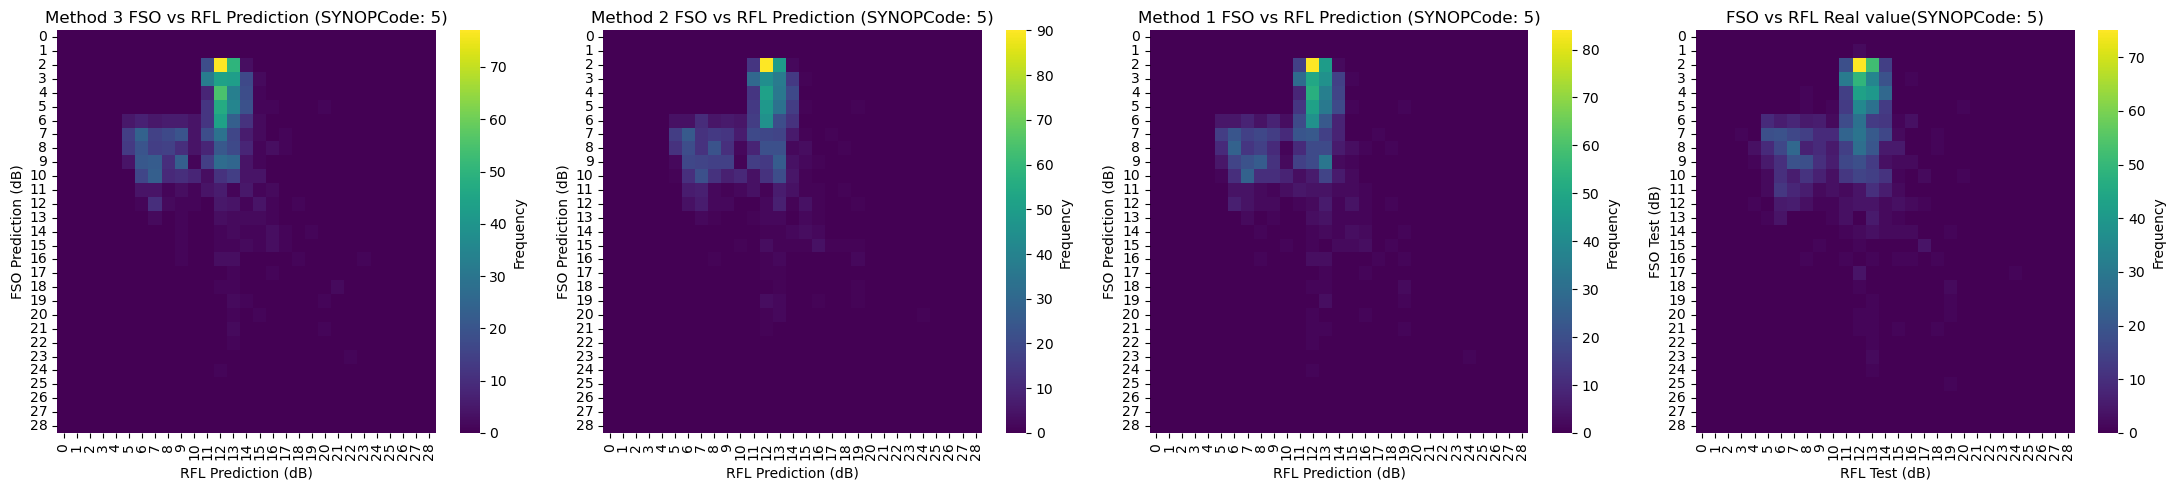

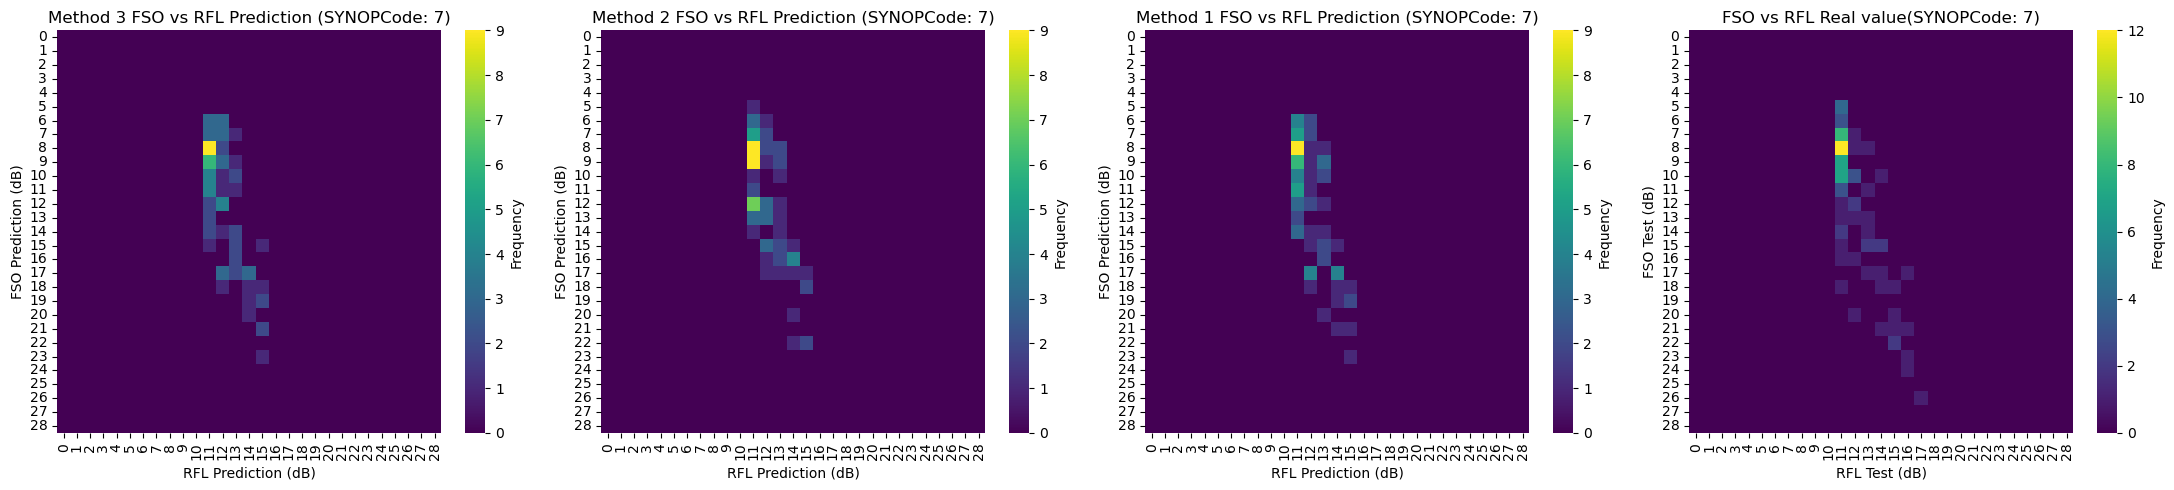

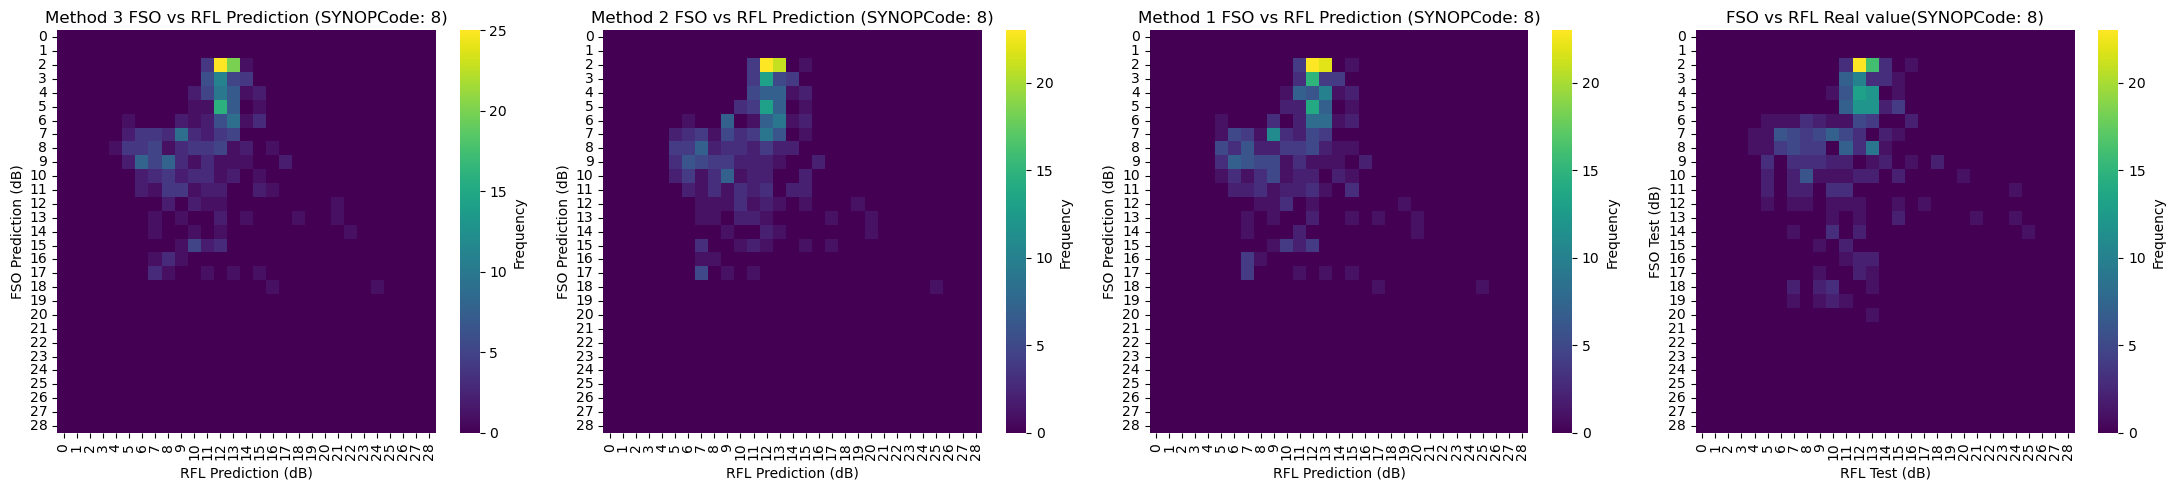

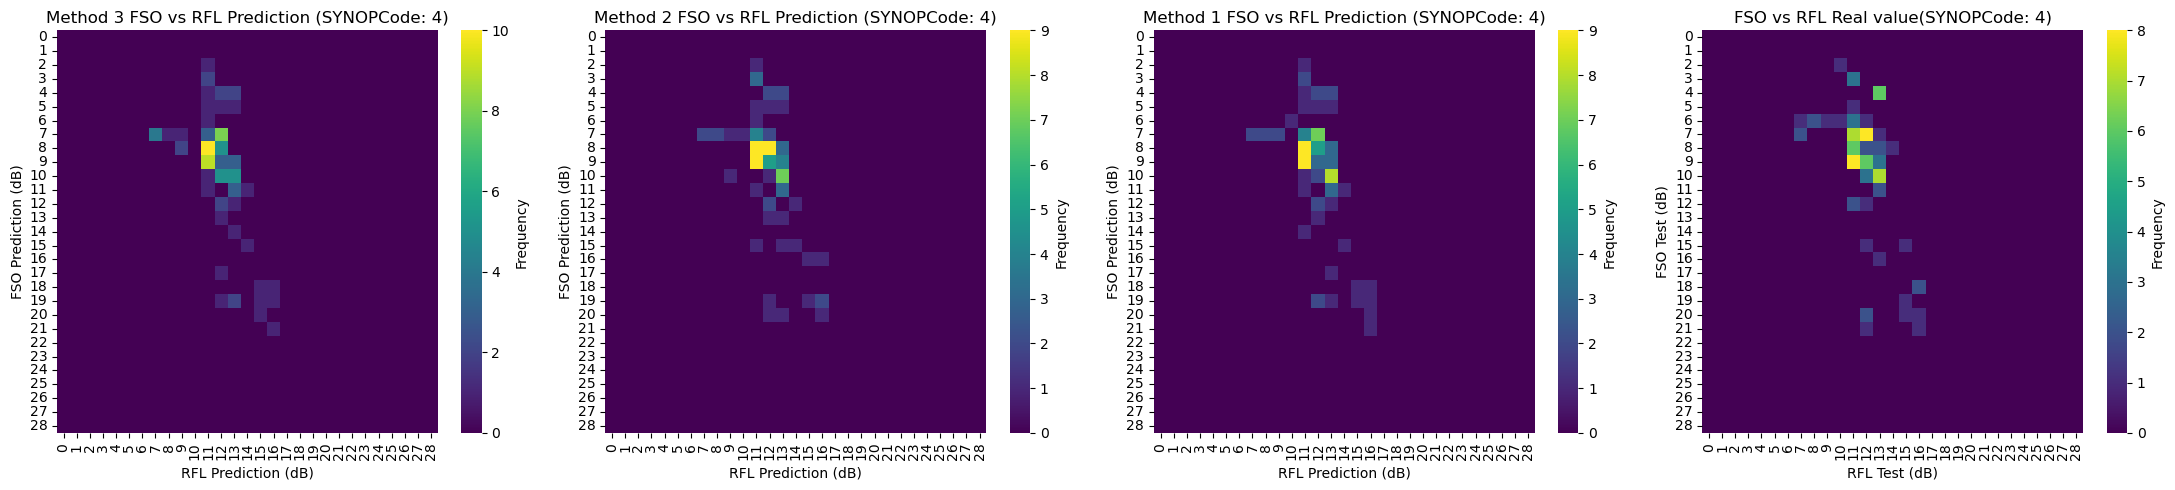

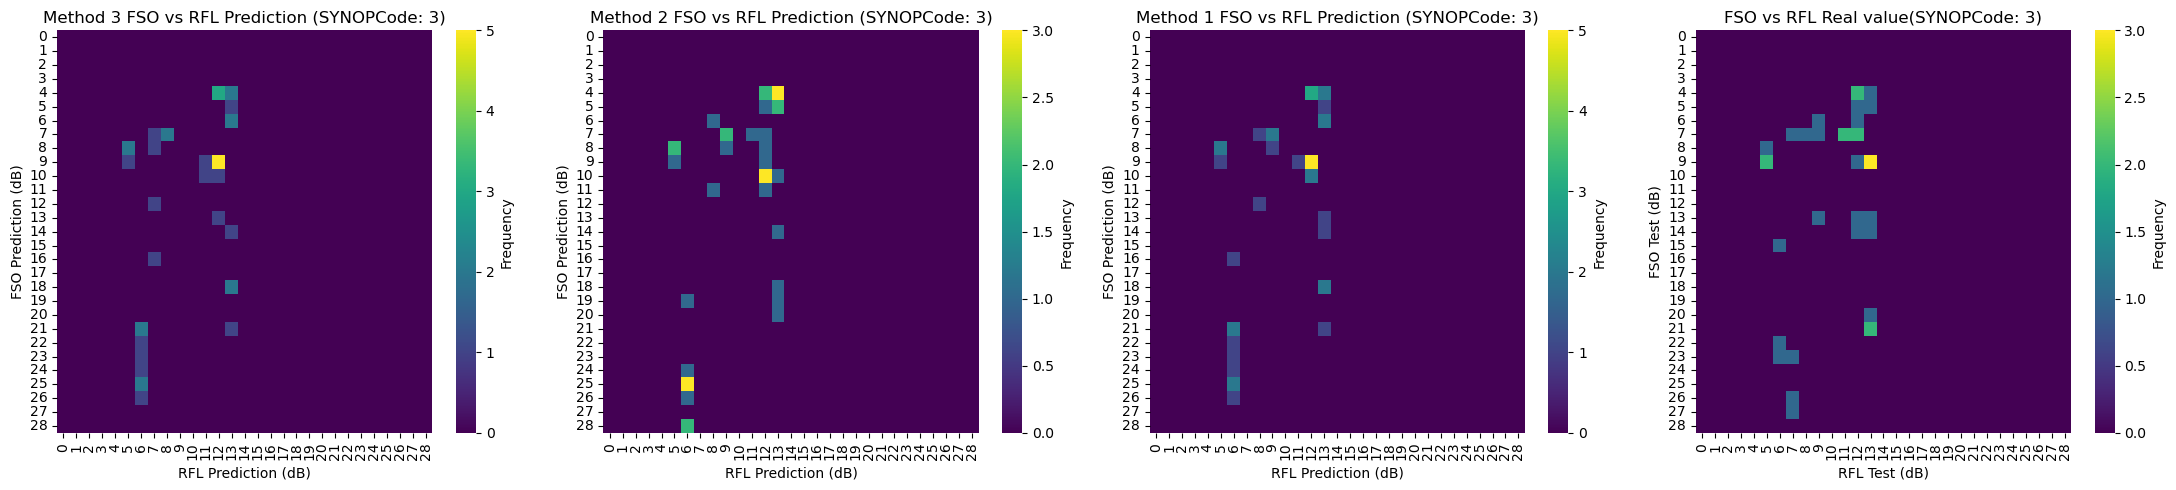

In [16]:
#generating heat map
#bin size
bin_size = 1
bins_fso = np.arange(0, 30, bin_size) 
bins_rfl = np.arange(0, 30, bin_size)  
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22,5), sharex=False, sharey=False)
    h_data_3, x3, y3 = np.histogram2d(
        subset['y_pred_RFL_2'], 
        subset['FSO_pred_1'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_3.T,
        xticklabels=np.round(x3[:-1], 1),
        yticklabels=np.round(y3[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax1
    )
    ax1.set_title(f'Method 3 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax1.set_xlabel('RFL Prediction (dB)')
    ax1.set_ylabel('FSO Prediction (dB)')

    h_data_2, x2, y2 = np.histogram2d(
        subset['RFL_pred_1'],  
        subset['y_pred_FSO_2'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_2.T,
        xticklabels=np.round(x2[:-1], 1),
        yticklabels=np.round(y2[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax2
    )
    ax2.set_title(f'Method 2 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax2.set_xlabel('RFL Prediction (dB)')
    ax2.set_ylabel('FSO Prediction (dB)')

    h_data_1, x1, y1 = np.histogram2d(
        subset['RFL_pred_1'], 
        subset['FSO_pred_1'],
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data_1.T,
        xticklabels=np.round(x1[:-1], 1),
        yticklabels=np.round(y1[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax3
    )
    ax3.set_title(f'Method 1 FSO vs RFL Prediction (SYNOPCode: {synop_code})')
    ax3.set_xlabel('RFL Prediction (dB)')
    ax3.set_ylabel('FSO Prediction (dB)')

    h_data, x, y = np.histogram2d(
        subset['y_RFL_test'],
        subset['y_FSO_test'], 
        bins=[bins_rfl, bins_fso]
    )
    sns.heatmap(
        h_data.T,
        xticklabels=np.round(x[:-1], 1),
        yticklabels=np.round(y[:-1], 1),
        cmap='viridis',
        cbar_kws={'label': 'Frequency'},
        ax=ax4
    )
    ax4.set_title(f'FSO vs RFL Real value(SYNOPCode: {synop_code})')
    ax4.set_xlabel('RFL Test (dB)')
    ax4.set_ylabel('FSO Test (dB)')

    plt.tight_layout()
    plt.show()

In [17]:
#calculate pearson corelation coefficient for method 3
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['y_pred_RFL_2']
    fso_values = subset['FSO_pred_1']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['y_pred_RFL_2'], results['FSO_pred_1'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for method 2
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_pred_1']
    fso_values = subset['y_pred_FSO_2']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['RFL_pred_1'], results['y_pred_FSO_2'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for method 1
pearson_results = {}
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_pred_1']
    fso_values = subset['FSO_pred_1']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(results['RFL_pred_1'], results['FSO_pred_1'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

#calculate pearson corelation coefficient for real value
pearson_results = {}
for synop_code in df['SYNOPCode'].unique():
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_Att']
    fso_values = subset['FSO_Att']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(df['RFL_Att'], df['FSO_Att'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

  SYNOPCode  Pearson_Correlation
0         6             0.366818
1         0            -0.306009
2         5            -0.151718
3         7             0.761200
4         8            -0.245270
5         4             0.598580
6         3            -0.453216
7   Overall             0.089744
  SYNOPCode  Pearson_Correlation
0         6             0.357557
1         0            -0.301122
2         5            -0.187342
3         7             0.749547
4         8            -0.275362
5         4             0.575662
6         3            -0.565924
7   Overall             0.088909
  SYNOPCode  Pearson_Correlation
0         6             0.355041
1         0            -0.297203
2         5            -0.170331
3         7             0.745839
4         8            -0.260499
5         4             0.600076
6         3            -0.520210
7   Overall             0.090509
  SYNOPCode  Pearson_Correlation
0         0            -0.267705
1         6             0.348307
2         

In [18]:
#calculate pearson corelation coefficient for real value in complete dataset
pearson_results = {}
for synop_code in df['SYNOPCode'].unique():
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_values = subset['RFL_Att']
    fso_values = subset['FSO_Att']
    pearson_corr = np.corrcoef(rfl_values, fso_values)[0, 1]
    pearson_results[synop_code] = pearson_corr
overall_pearson_corr = np.corrcoef(df['RFL_Att'], df['FSO_Att'])[0, 1]
pearson_results['Overall'] = overall_pearson_corr
pearson_df = pd.DataFrame(list(pearson_results.items()), columns=['SYNOPCode', 'Pearson_Correlation'])
print(pearson_df)

  SYNOPCode  Pearson_Correlation
0         0            -0.267705
1         6             0.348307
2         8            -0.169827
3         5            -0.155631
4         3            -0.424294
5         4             0.577887
6         7             0.804480
7   Overall             0.089866


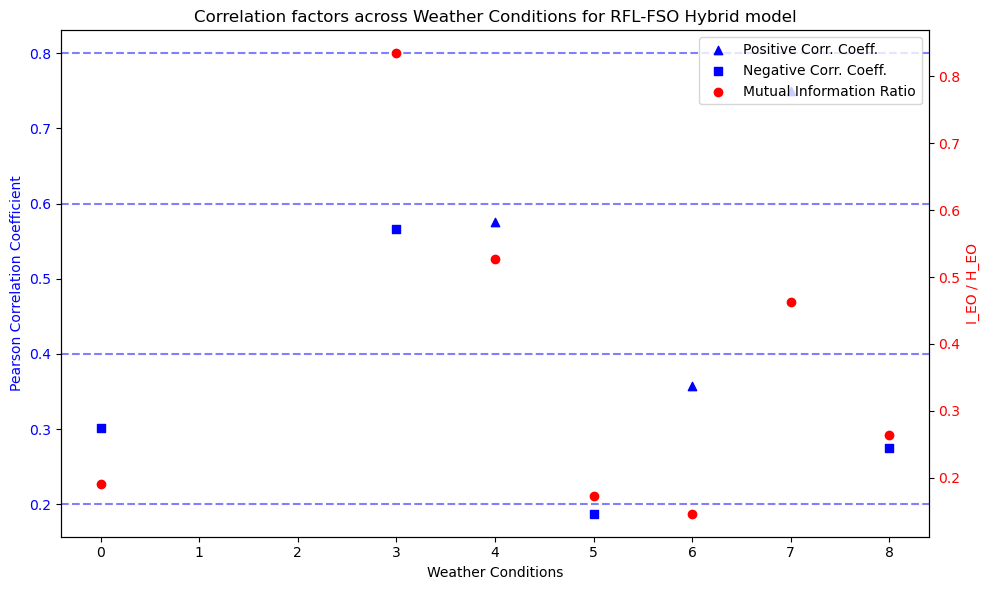

In [19]:
#generate graph for both pearson and mutual imformation/ joint entrophy

from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score

weather_conditions = results['SYNOPCode'].unique()
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

for synop_code in weather_conditions:
    subset = results[results['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['y_pred_FSO_2']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    #mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  # 自己的熵
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

#plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# scatter plot for pearson
ax1.scatter(weather_conditions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(weather_conditions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions')
ax1.set_ylabel('Pearson Correlation Coefficient', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(0.8, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.6, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.4, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(0.2, color='blue', linestyle='--', alpha=0.5)

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(weather_conditions, mutual_info_ratios, c='red', marker='o', label='Mutual Information Ratio')
ax2.set_ylabel('I_EO / H_EO', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.title('Correlation factors across Weather Conditions for RFL-FSO Hybrid model')
plt.tight_layout()
plt.show()

   SYNOPCode  RFL-FSO_RMSE  RFL-FSO_R2  FSO-RFL_RMSE  FSO-RFL_R2  \
0          6      1.135502    0.931699      1.154455    0.923325   
1          0      1.060585    0.912966      0.568375    0.950269   
2          5      1.014884    0.920423      0.757892    0.930247   
3          7      1.815381    0.872078      0.592629    0.848698   
4          8      1.220691    0.918277      1.107333    0.873050   
5          4      1.003081    0.943527      0.675428    0.837559   
6          3      2.034342    0.940037      0.677133    0.950661   

   Independent_FSO_RMSE  Independent_FSO_R2  Independent_RFL_RMSE  \
0              1.080126            0.938198              1.088314   
1              1.035599            0.917019              0.585680   
2              0.995738            0.923397              0.731141   
3              1.447428            0.918679              0.619196   
4              1.218930            0.918512              1.097239   
5              0.745158            0.9688

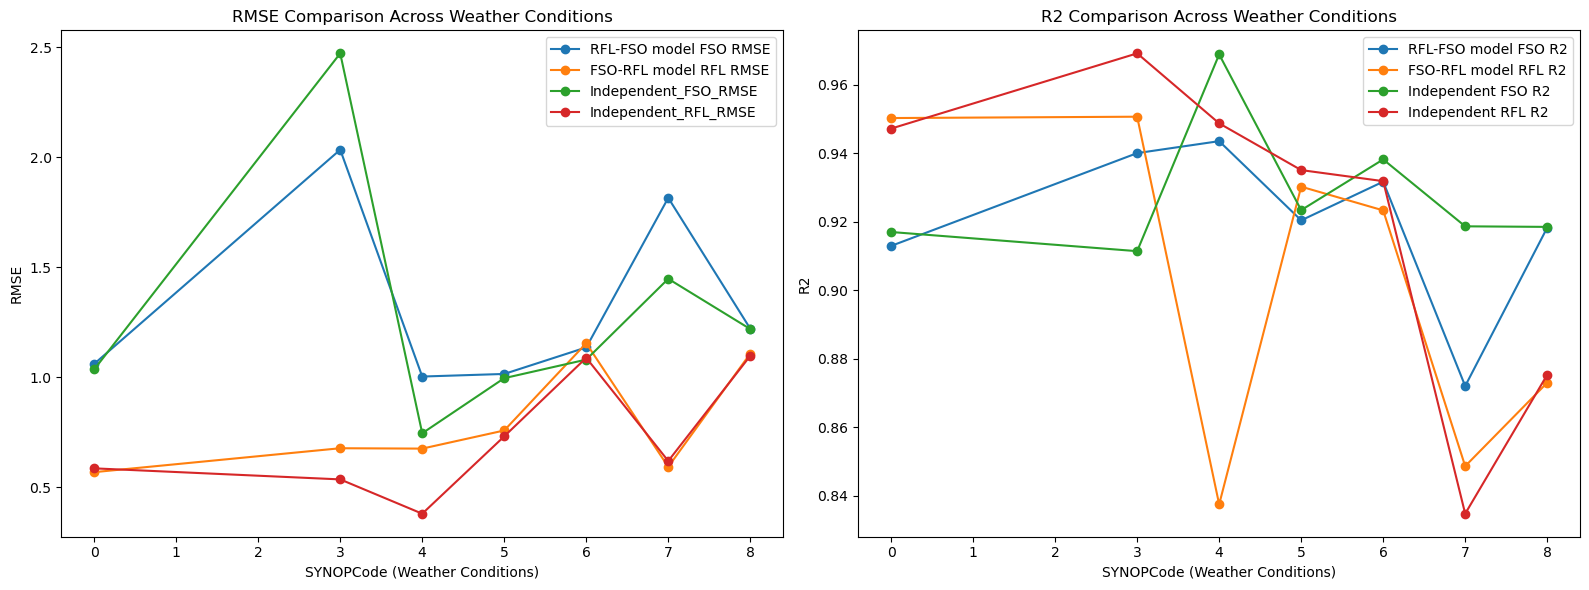

In [23]:
# define function to calculate rmse and r2
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# initialize dict 
metrics = {
    'SYNOPCode': [],
    'RFL-FSO_RMSE': [],
    'RFL-FSO_R2': [],
    'FSO-RFL_RMSE': [],
    'FSO-RFL_R2': [],
    'Independent_FSO_RMSE': [],
    'Independent_FSO_R2': [],
    'Independent_RFL_RMSE': [],
    'Independent_RFL_R2': []
}

# calculate by different synopcode
for synop_code in results['SYNOPCode'].unique():
    subset = results[results['SYNOPCode'] == synop_code]
    
    # RFL-FSO model fso
    rmse_rfl_fso, r2_rfl_fso = calculate_metrics(subset['y_FSO_test'], subset['y_pred_FSO_2'])
    
    # FSO-RFL model RFL 
    rmse_fso_rfl, r2_fso_rfl = calculate_metrics(subset['y_RFL_test'], subset['y_pred_RFL_2'])
    
    # independent model FSO
    rmse_FSO_independent, r2_FSO_independent = calculate_metrics(subset['y_FSO_test'], subset['FSO_pred_1'])
    
    # independent model RFL
    rmse_RFL_independent, r2_RFL_independent = calculate_metrics(subset['y_RFL_test'], subset['RFL_pred_1'])
    
    # save result
    metrics['SYNOPCode'].append(synop_code)
    metrics['RFL-FSO_RMSE'].append(rmse_rfl_fso)
    metrics['RFL-FSO_R2'].append(r2_rfl_fso)
    metrics['FSO-RFL_RMSE'].append(rmse_fso_rfl)
    metrics['FSO-RFL_R2'].append(r2_fso_rfl)
    metrics['Independent_FSO_RMSE'].append(rmse_FSO_independent)
    metrics['Independent_FSO_R2'].append(r2_FSO_independent)
    metrics['Independent_RFL_RMSE'].append(rmse_RFL_independent)
    metrics['Independent_RFL_R2'].append(r2_RFL_independent)    
# transform result to dataframe
metrics_df = pd.DataFrame(metrics)

# print result
print(metrics_df)

# sort by synopcode
metrics_df_sorted = metrics_df.sort_values(by='SYNOPCode')

# plotting
plt.figure(figsize=(16,6))

# plot RMSE 
plt.subplot(1, 2, 1)
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['RFL-FSO_RMSE'], label='RFL-FSO model FSO RMSE', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['FSO-RFL_RMSE'], label='FSO-RFL model RFL RMSE', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_FSO_RMSE'], label='Independent_FSO_RMSE', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_RFL_RMSE'], label='Independent_RFL_RMSE', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Weather Conditions')
plt.legend()

# plot r2
plt.subplot(1, 2, 2)
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['RFL-FSO_R2'], label='RFL-FSO model FSO R2', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['FSO-RFL_R2'], label='FSO-RFL model RFL R2', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_FSO_R2'], label='Independent FSO R2', marker='o')
plt.plot(metrics_df_sorted['SYNOPCode'], metrics_df_sorted['Independent_RFL_R2'], label='Independent RFL R2', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('R2')
plt.title('R2 Comparison Across Weather Conditions')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
results.to_csv('projectB_split_dataset_results.csv')